# Imports

In [1]:
from utils import *
import os
import shutil
from PIL import Image
from pytorch_fid import fid_score
import copy
import torch.distributions as D

import torch
import numpy as np

import torch.optim.lr_scheduler as lrsc
import wandb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

from config_cifar10_32 import *
config = get_configs()


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
wandb.login()
train_loader, val_loader = get_dataset_CIFAR10(config)

wandb: Currently logged in as: vvoganesyan (use `wandb login --relogin` to force relogin)


Files already downloaded and verified
Files already downloaded and verified


In [23]:
beta_0 = 0.1
beta_1 = 20
N = 1000
T = 1   
def rsde(x, t, model):
    
    beta_t = beta_0 + t * (beta_1 - beta_0)
    drift = -0.5 * beta_t[:, None, None, None] * x
    diffusion = torch.sqrt(beta_t)

    score = model(t * 999, x)
    log_mean_coeff = -0.25 * t ** 2 * (beta_1 - beta_0) - 0.5 * t * beta_0
    std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
    score = -score / std[:, None, None, None]


    drift = drift - diffusion[:, None, None, None] ** 2 * score
    return drift, diffusion

def pc_sampler(model):
    shape = (128, 3, 32, 32)
    dt = -1. / N
    with torch.no_grad():
        x = torch.randn(*shape).to(device)
        t = T

        for i in range(N):
            vec_t = torch.ones(shape[0], device=device) * t
            
            z = torch.randn_like(x)
            drift, diffusion = rsde(x, vec_t, model)
            x = x + drift * dt + diffusion[:, None, None, None] * np.sqrt(-dt) * z
            t = t + dt
    return x

In [27]:
sam = pc_sampler(eps_th)
display_samples(sam)

# Sampling

In [2]:
eps_th = Unet(config)
eps_th.to(device)
ema_ = ema.ExponentialMovingAverage(eps_th.parameters(), decay=0.9999)

In [3]:
# state = torch.load(config.model.savepath)
state = torch.load('checkpoint_21.pth')
eps_th.load_state_dict(state['model'], strict=False)
ema_.load_state_dict(state['ema'])

In [4]:
ema_.copy_to(eps_th.parameters())
eps_th.eval()

Unet(
  (unet): DDPM(
    (act): SiLU()
    (all_modules): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
      (2): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Dense_0): Linear(in_features=512, out_features=128, bias=True)
        (GroupNorm_1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (Dropout_0): Dropout(p=0.1, inplace=False)
        (Conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Dense_0): Linear(in_features

# One model

In [ ]:
with torch.no_grad():
    save_callable(lambda: sample_sde(device, eps_th, config.data.image_size, config.data.num_channels, 128, [])[0], "samples_32_song", [config.data.norm_mean, config.data.norm_std], 50000)

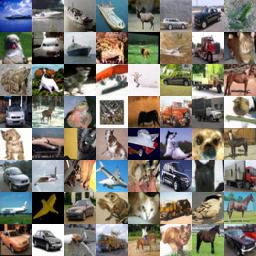

In [6]:
big_img = np.zeros((8*32,8*32,3),dtype=np.uint8)
for i in range(8):
    for j in range(8):
        im = Image.open(f"samples_32_song/{i*8+j}.png")
        big_img[i*32:(i+1)*32, j*32:(j+1)*32, :] = np.array(im)
big_img = Image.fromarray(big_img)
big_img

In [15]:
save_dataloader(train_loader, 'data_1', 128*128)

In [20]:
res = fid_score.calculate_fid_given_paths(
        paths=['real_images', 'samples_32'],
        batch_size=128,
        device=device,
        dims=2048
    )
print(res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [01:51<00:00,  3.50it/s]


4.2377748437494915
